# Importar bibliotecas

In [1]:
! pip install cx-Oracle
! pip install pycep_correios

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)# Removendo notações científicas
import requests, json
from Conexão_Banco_de_Dados_Oracle import conectar_bd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(suppress=False) # Removendo notações científicas
from pycep_correios import get_address_from_cep, WebService
import math
from datetime import datetime

# Remover warnings dos kernels
import warnings
warnings.filterwarnings('ignore')

# Conectar ao banco de dados (cursor)

In [3]:
conn = conectar_bd()
cursor = conn.cursor()

# Extrair informações dos clientes via banco de dados

In [4]:
# Dados cadastrais
cons_empresas_cadastradas = '''
SELECT 
    a.CODEMPRESA, a.RAZAOSOCIAL, a.NOMEFANTASIA, 
    d.CEP, d.NUMCNPJCPF
FROM HINOERP_BIO.GEEMPRESA a
    LEFT JOIN HINOERP_BIO.GEEMPRESAPARAMESTAB b
        ON a.CODEMPRESA = b.CODEMPRESA
    LEFT JOIN HINOERP_BIO.GEENDEMPRESA c
        ON a.CODEMPRESA = c.CODEMPRESA
    LEFT JOIN HINOERP_BIO.GEENDERECO d
        ON c.CODENDERECO = d.CODENDERECO
    WHERE TIPOEMPRESA = 'C' AND LENGTH(d.NUMCNPJCPF) = 14
'''
df_empresas_cadastradas = pd.read_sql(cons_empresas_cadastradas, conn)

# Retornando data de cadastro das empresas
cons = '''
SELECT e.DATALOG as DATACADASTRO, PARA AS CODEMPRESA
FROM HINOERP_BIO.GELOG E
LEFT JOIN HINOERP_BIO.GELOGDET b
ON E.CODLOG = b.CODLOG
WHERE TABELA = 'GEEMPRESA' AND CAMPO = 'Cód. Empresa' AND DE IS NULL
'''
datas_cadastros = pd.read_sql(cons, conn)
datas_cadastros['CODEMPRESA'] = datas_cadastros['CODEMPRESA'].astype(int)

# Merge das informações
df_empresas_cadastradas = df_empresas_cadastradas.merge(datas_cadastros, on='CODEMPRESA', how='left')

# Dados financeiros
cons_dados_financeiros = '''
SELECT 
    e.CODEMPRESA, 
    SUM(e.VALORORIGINAL) AS TOTALVENDAS, 
    AVG(e.VALORJUROS) AS MEDIAJUROS, 
    AVG(e.DATALIQUIDACAO - e.DATAVENCIMENTO) AS DIASATRASO
FROM HINOERP_BIO.FITITULOS e
WHERE e.INDICENFSAIDA IS NOT NULL
GROUP BY CODEMPRESA
'''

df_titulos = pd.read_sql(cons_dados_financeiros, conn)

# Unindo as informações
df = df_empresas_cadastradas.merge(df_titulos, on='CODEMPRESA', how='left').fillna(0)
df.index = [i for i in range(df.shape[0])]

# Extrair informações extras dos clientes via request

In [5]:
# Função de extração de dados do CNPJ
def _dados_cnpj(cnpj):
    return json.loads(requests.get(f'https://thecollector.linkana.com/companies?cnpj=eq.{cnpj}&limit=1%27').text)[0]

# Buscando informações de geolocalização
def busca_geolocation(cep):
    try:
        # Ajustar para parametro de pesquisa URL
        '''
        Obs: Foi acrescentado o replace para Bonfim Paulista pois era uma exceção que estava ocasionando erros "desenecessários"
        '''
        r = lambda x: x.replace('Bonfim Paulista (Ribeirão Preto)', 'Ribeirão Preto').replace(' ', '+')

        URL = "https://nominatim.openstreetmap.org/search?format=json&addressdetails=1&country=$brazil&state=${}&city=${}&limit=1"
        infos = get_address_from_cep(cep, webservice=WebService.CORREIOS)
        dados_cep = json.loads(requests.get(URL.format(infos['uf'], r(infos['cidade']))).text)[0]

        return (dados_cep['lat'], dados_cep['lon'], dados_cep['importance'], dados_cep['address']['state_district'])
    except:
        return (np.nan, np.nan, np.nan, np.nan)

In [6]:
# Teste função de geolocalização
busca_geolocation('44025930')

(nan, nan, nan, nan)

In [7]:
# Criação de um dicionário auxiliar
dict_aux = {
    'Data Abertura CNPJ': [],
    'Capital Social': [],
    'Natureza Jurídica': [],
    'Porte': [],
    "CNAE's": [],
    "Latitude": [],
    "Longitude": [],
    "NvlImportanciaGEO": [],
    "Região": []
}

# Alimentando o dicionário auxiliar
for i, cnpj in enumerate(df['NUMCNPJCPF']):
    dados_consulta_cnpj = _dados_cnpj(cnpj)
    lat, lon, importance, regiao = busca_geolocation(dados_consulta_cnpj['cep'])
    
    # Dados geolocalização
    dict_aux['Latitude'].append(lat)
    dict_aux['Longitude'].append(lon)
    dict_aux['NvlImportanciaGEO'].append(importance)
    dict_aux['Região'].append(regiao)
    
    # Dados CNPJ
    dict_aux['Data Abertura CNPJ'].append(dados_consulta_cnpj['data_inicio_atividade'])
    dict_aux['Capital Social'].append(str(dados_consulta_cnpj['capital_social'])[:-2])
    dict_aux['Natureza Jurídica'].append(dados_consulta_cnpj['natureza_juridica'])
    dict_aux['Porte'].append(dados_consulta_cnpj['cod_porte_empresa'])
    cnaes = [dados_consulta_cnpj['cnae_fiscal']]
    if dados_consulta_cnpj['cnaes_secundarios'] != None:
        cnaes = cnaes + dados_consulta_cnpj['cnaes_secundarios']
    dict_aux["CNAE's"].append(cnaes)
    

    print(f'{i + 1} / {df.shape[0] } - {regiao}')

# Transformando o DF auxiliar em objeto Pandas e concatenando com o DF de infos baixadas
df_aux = pd.DataFrame.from_dict(dict_aux)

df = pd.concat([df, df_aux], axis=1)
df_backup1 = df

1 / 451 - Região Geográfica Intermediária de Bauru
2 / 451 - Região Geográfica Intermediária de Belo Horizonte
3 / 451 - Região Geográfica Intermediária de São Paulo
4 / 451 - Região Geográfica Intermediária do Rio de Janeiro
5 / 451 - Região Geográfica Intermediária de São Paulo
6 / 451 - Região Geográfica Intermediária de Cuiabá
7 / 451 - Região Geográfica Intermediária de Campinas
8 / 451 - Região Geográfica Intermediária de São Paulo
9 / 451 - Região Geográfica Intermediária de São Paulo
10 / 451 - Região Geográfica Intermediária de São Paulo
11 / 451 - Região Geográfica Intermediária de Belo Horizonte
12 / 451 - Região Geográfica Intermediária de Campinas
13 / 451 - Região Geográfica Intermediária de Goiânia
14 / 451 - Região Geográfica Intermediária do Distrito Federal
15 / 451 - Região Geográfica Intermediária de Ribeirão Preto
16 / 451 - Região Geográfica Intermediária de Sorocaba
17 / 451 - Região Geográfica Intermediária de São Paulo
18 / 451 - Região Geográfica Intermediária

144 / 451 - Região Geográfica Intermediária de Cuiabá
145 / 451 - Região Geográfica Intermediária de Campinas
146 / 451 - Região Geográfica Intermediária de São Paulo
147 / 451 - Região Geográfica Intermediária de Goiânia
148 / 451 - Região Geográfica Intermediária de Aracaju
149 / 451 - Região Geográfica Intermediária do Recife
150 / 451 - Região Geográfica Intermediária de São Paulo
151 / 451 - Região Geográfica Intermediária de São Paulo
152 / 451 - Região Geográfica Intermediária de Campinas
153 / 451 - Região Geográfica Intermediária de São Paulo
154 / 451 - Região Geográfica Intermediária de Belo Horizonte
155 / 451 - Região Geográfica Intermediária de Juiz de Fora
156 / 451 - Região Geográfica Intermediária de Montes Claros
157 / 451 - Região Geográfica Intermediária de São Paulo
158 / 451 - Região Geográfica Intermediária de São Paulo
159 / 451 - Região Geográfica Intermediária de Belo Horizonte
160 / 451 - Região Geográfica Intermediária de São Paulo
161 / 451 - Região Geográf

285 / 451 - Região Geográfica Intermediária de Porto Alegre
286 / 451 - Região Geográfica Intermediária de São Paulo
287 / 451 - Região Geográfica Intermediária de Fortaleza
288 / 451 - Região Geográfica Intermediária de Palmas
289 / 451 - Região Geográfica Intermediária de São Paulo
290 / 451 - Região Geográfica Intermediária do Rio de Janeiro
291 / 451 - Região Geográfica Intermediária do Distrito Federal
292 / 451 - Região Geográfica Intermediária de São Paulo
293 / 451 - Região Geográfica Intermediária de Curitiba
294 / 451 - Região Geográfica Intermediária de São Paulo
295 / 451 - Região Geográfica Intermediária de Manaus
296 / 451 - Região Geográfica Intermediária de Belo Horizonte
297 / 451 - Região Geográfica Intermediária de São Paulo
298 / 451 - Região Geográfica Intermediária de Belo Horizonte
299 / 451 - Região Geográfica Intermediária de São Paulo
300 / 451 - Região Geográfica Intermediária de São Paulo
301 / 451 - Região Geográfica Intermediária do Distrito Federal
302 / 

428 / 451 - Região Geográfica Intermediária de Belo Horizonte
429 / 451 - Região Geográfica Intermediária de Governador Valadares
430 / 451 - Região Geográfica Intermediária de São Paulo
431 / 451 - Região Geográfica Intermediária de Maceió
432 / 451 - Região Geográfica Intermediária de Teresina
433 / 451 - Região Geográfica Intermediária de Fortaleza
434 / 451 - Região Geográfica Intermediária de Curitiba
435 / 451 - Região Geográfica Intermediária de Salvador
436 / 451 - Região Geográfica Intermediária de São Paulo
437 / 451 - Região Geográfica Intermediária de São Paulo
438 / 451 - Região Geográfica Intermediária de Fortaleza
439 / 451 - Região Geográfica Intermediária de Goiânia
440 / 451 - Região Geográfica Intermediária de São José do Rio Preto
441 / 451 - Região Geográfica Intermediária de São Paulo
442 / 451 - Região Geográfica Intermediária de Ribeirão Preto
443 / 451 - Região Geográfica Intermediária de Goiânia
444 / 451 - Região Geográfica Intermediária de Araraquara
445 / 4

# Pré-tratamento do DF

In [22]:
# Preenchendo a feature  de data de cadastro (clientes que foram cadastrados na importação)
df.loc[df['DATACADASTRO'] == 0, 'DATACADASTRO'] = datetime(year=2021, month=1, day=10)
df['DATACADASTRO'].isna().sum()

0

In [23]:
# Dummies de CNAE's
df = df.explode("CNAE's")

Percentual  de CNAE's atendidos:  0.7097270280661284


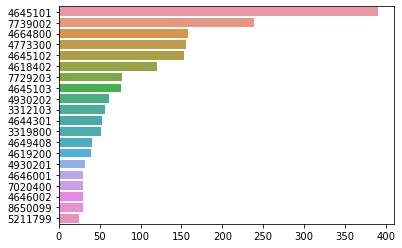

In [24]:
dist_cnaes = df["CNAE's"].value_counts()
sns.barplot(dist_cnaes[:20].values, dist_cnaes[:20].index)
print("Percentual  de CNAE's atendidos: ", sum(dist_cnaes[:20] / df.shape[0]))

Devido ao grande número de CNAE's, decidi por reduzir a dimensionalidade destes valores antes de tratar o DF mais a frente, mantendo apenas os top 20 CNAE's mais frequentes das empresas cadastradas.

In [25]:
df = df.loc[df["CNAE's"].isin(dist_cnaes[:20].index)]

dummies = pd.get_dummies(df["CNAE's"])
df = df.drop("CNAE's", axis=1)
df = pd.concat([df, dummies], axis=1)
df = df[~df.index.duplicated(keep='first')]

# Salvando um backup do df caso precise no futuro
df_backup = df.copy()

# I - EDA - Análise Exploratória de Dados

In [26]:
df.head()

,CODEMPRESA,RAZAOSOCIAL,NOMEFANTASIA,CEP,NUMCNPJCPF,DATACADASTRO,TOTALVENDAS,MEDIAJUROS,DIASATRASO,Data Abertura CNPJ,Capital Social,Natureza Jurídica,Porte,Latitude,Longitude,NvlImportanciaGEO,Região,3312103,3319800,4618402,4619200,4644301,4645101,4645102,4645103,4646001,4646002,4649408,4664800,4773300,4930201,4930202,5211799,7020400,7729203,7739002,8650099
0,364,GETMED - DISTRIBUIDORA MEDICO HOSPITALAR LTDA,GETMED,17016160,01631872000110,2021-01-06 20:04:00,0.000,0.000,-6.000,1997-01-28T00:00:00,200000,Sociedade Empresária Limitada,05,-22.3218102,-49.0705863,0.652,Região Geográfica Intermediária de Bauru,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,366,ORION COMERCIO DE PRODUTOS MEDICOS LTDA,ORION COMERCIO DE PRODUTOS MEDICOS LTDA,30150010,21169862000112,2021-01-07 18:55:02,0.000,0.000,0.000,2014-10-06T00:00:00,110000,Empresa Individual de Responsabilidade Limitad...,03,-19.9227318,-43.9450948,0.825,Região Geográfica Intermediária de Belo Horizonte,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,367,"OSTEO SOLUTION - COMERCIO, IMPORTACAO E EXPORT...","OSTEO SOLUTION - COMERCIO, IMPORTACAO E EXPORT...",04038002,07585476000180,2021-01-07 19:03:19,0.000,0.000,0.000,2005-08-01T00:00:00,320000,Sociedade Empresária Limitada,05,-23.5506507,-46.6333824,0.886,Região Geográfica Intermediária de São Paulo,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,368,PATMUS PRODUTOS MEDICOS E HOSPITALARES LTDA,CHRONUS PRODUTOS MEDICOS HOSPITALARES,22775022,13181174000140,2021-01-07 19:47:13,52390.030,12.049,6.893,2010-11-05T00:00:00,20000,Sociedade Empresária Limitada,01,-22.9110137,-43.2093727,1.015,Região Geográfica Intermediária do Rio de Janeiro,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,369,RADIOMED COMERCIO E IMPORTACAO LTDA,ILIKIA,01424906,71785687000166,2021-01-08 10:44:39,187989.810,0.134,0.472,1993-06-29T00:00:00,3000000,Sociedade Empresária Limitada,05,-23.5506507,-46.6333824,0.886,Região Geográfica Intermediária de São Paulo,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
df.tail()

,CODEMPRESA,RAZAOSOCIAL,NOMEFANTASIA,CEP,NUMCNPJCPF,DATACADASTRO,TOTALVENDAS,MEDIAJUROS,DIASATRASO,Data Abertura CNPJ,Capital Social,Natureza Jurídica,Porte,Latitude,Longitude,NvlImportanciaGEO,Região,3312103,3319800,4618402,4619200,4644301,4645101,4645102,4645103,4646001,4646002,4649408,4664800,4773300,4930201,4930202,5211799,7020400,7729203,7739002,8650099
446,880,GEO REPRESENTACAO E COMERCIO DE MATERIAIS MEDI...,GEOMED,88075001,24707110000156,2022-08-11 19:22:18,2282.830,0.000,0.000,2016-05-02T00:00:00,5000,Sociedade Empresária Limitada,03,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
447,901,"TRIADE IMPLANTES - COMERCIO, IMPORTACAO E EXPO...",GRUPO ALLERE,12243000,10381270000143,2022-08-29 18:42:04,0.000,0.000,0.000,2008-09-19T00:00:00,50000,Sociedade Empresária Limitada,05,-23.1860383,-45.8866816,0.949,Região Geográfica Intermediária de São José do...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
448,911,MARCIO DA SILVA SANTOS,MEDSYS SURGICAL COMERCIO DE MATERIAL HOSPITALAR,11025002,08072196000131,2022-09-21 11:38:38,8174.020,0.000,0.000,2006-04-03T00:00:00,100000,Sociedade Empresária Limitada,01,-23.960833,-46.333889,0.682,Região Geográfica Intermediária de São Paulo,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
449,937,RHINUS MEDICAL COMERCIO DE MATERIAL HOSPITALAR...,ALPHA SURGICAL,25070350,10983985000176,2022-10-13 11:56:05,0.000,0.000,0.000,2009-07-07T00:00:00,4320000,Sociedade Empresária Limitada,03,-22.7896225,-43.309929,0.768,Região Geográfica Intermediária do Rio de Janeiro,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
450,944,PROASIST RIO COMERCIO E SERVICOS LTDA,PROASIST RIO COMERCIO E SERVICOS LTDA,22793081,17273344000177,2022-10-21 18:42:24,0.000,0.000,0.000,2012-12-07T00:00:00,310000,Sociedade Empresária Limitada,05,-22.9110137,-43.2093727,1.015,Região Geográfica Intermediária do Rio de Janeiro,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## I.I - Análise estrutural

In [28]:
rows_df = df.shape[0]
cols_df = df.shape[1]
print(f'Quantidade total de linhas: {rows_df}\nQuantidade total de colunas: {cols_df}')

Quantidade total de linhas: 428
Quantidade total de colunas: 37


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 450
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CODEMPRESA          428 non-null    int64  
 1   RAZAOSOCIAL         428 non-null    object 
 2   NOMEFANTASIA        428 non-null    object 
 3   CEP                 428 non-null    object 
 4   NUMCNPJCPF          428 non-null    object 
 5   DATACADASTRO        428 non-null    object 
 6   TOTALVENDAS         428 non-null    float64
 7   MEDIAJUROS          428 non-null    float64
 8   DIASATRASO          428 non-null    float64
 9   Data Abertura CNPJ  428 non-null    object 
 10  Capital Social      428 non-null    object 
 11  Natureza Jurídica   428 non-null    object 
 12  Porte               428 non-null    object 
 13  Latitude            421 non-null    object 
 14  Longitude           421 non-null    object 
 15  NvlImportanciaGEO   421 non-null    float64
 16  Região  

### Reajustando datatypes

In [30]:
df['Data Abertura CNPJ'] = pd.to_datetime(df['Data Abertura CNPJ'], format='%Y-%m-%d %H:%M:%S')
df['DATACADASTRO'] = pd.to_datetime(df['DATACADASTRO'], format='%Y-%m-%d %H:%M:%S')

In [31]:
df['Capital Social'].value_counts()

100000       74
200000       25
1000000      22
50000        21
10000        17
500000       14
300000       12
20000        12
120000        9
5000          8
80000         8
150000        7
93700         7
600000        7
400000        7
30000         7
250000        7
110000        6
60000         6
2000000       6
3000000       6
40000         6
95400         5
2500000       5
15000         4
105000        4
              3
230000        3
800000        3
750000        2
1500000       2
130000        2
350000        2
700000        2
1200000       2
104500        2
5000000       2
78800         2
4000000       2
2000          2
220000        2
610000        1
2164874       1
1000          1
72400         1
99990         1
65000         1
440000        1
25000000      1
99800         1
1494801       1
68269261      1
21009         1
1112256       1
180000        1
28500000      1
1125000       1
21573700      1
110195        1
210727        1
7800000       1
3863000       1
4320000 

In [32]:
df['Capital Social'] = df['Capital Social'].replace('', 0).astype(float)
df['Porte'] = df['Porte'].astype(int)
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

### Removendo colunas indesejadas
Colunas de identificação, localização (redundante).

In [33]:
df = df.drop(['CODEMPRESA', 'RAZAOSOCIAL', 'NOMEFANTASIA', 'CEP', 'NUMCNPJCPF'], axis=1)

## I.II - Análise Qualitativa

### Features categóricas

In [34]:
for feature_nn in df.dtypes[df.dtypes == object].index:
    print(feature_nn.center(100, '*'))
    print(f'{(sum(df[feature_nn].isna()) / rows_df) * 100:.2f}% das features são missing.')
    print(f'Dos {sum(~df[feature_nn].isna())}, sendo distribuidos em {len(df[feature_nn].value_counts())} valores diferentes.')

*****************************************Natureza Jurídica******************************************
0.00% das features são missing.
Dos 428, sendo distribuidos em 5 valores diferentes.
***********************************************Região***********************************************
1.64% das features são missing.
Dos 421, sendo distribuidos em 51 valores diferentes.


In [35]:
top_regioes = (df['Região'].value_counts() / rows_df)[df['Região'].value_counts() / rows_df > 0.02]

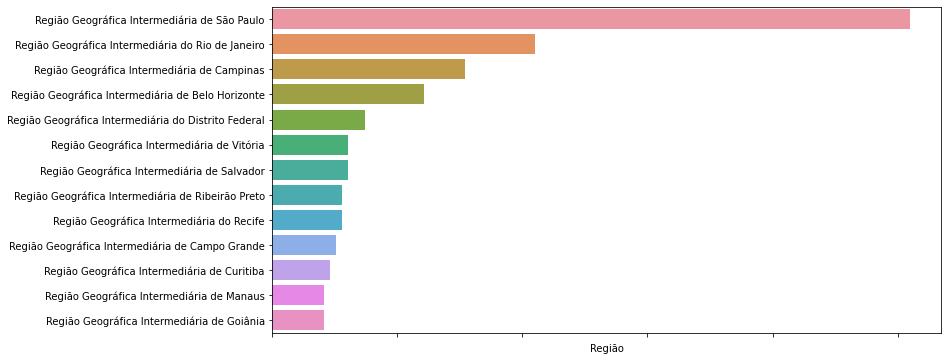

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(top_regioes, top_regioes.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [37]:
# Substituir regiões com baixa densidade de empresas cadastradas por "outra" (exceto NaN's).
df['Região'][(~df['Região'].isin(top_regioes.index)) & (~df['Região'].isna())] = 'Outra'

<AxesSubplot:ylabel='Porte'>

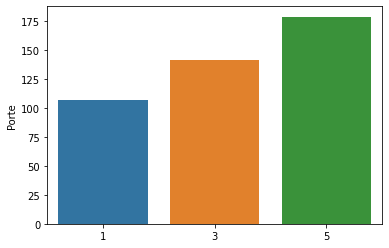

In [38]:
# Análise de portes das empresas
sns.barplot(df['Porte'].value_counts().index, df['Porte'].value_counts())

In [39]:
# Análise de correlação entre as duas features categóricas
analise_ft_cat = pd.concat([pd.get_dummies(df['Porte']), df['Região']], axis=1)
analise_ft_cat = analise_ft_cat.groupby(['Região'], as_index=False)[[1,3,5]].sum()
analise_ft_cat['Totais'] = analise_ft_cat[[1,3,5]].sum(axis=1)

df_exp = analise_ft_cat[[1,3,5]]
somas_cols = df_exp.sum(axis=0)
for col in df_exp:
    percent = (somas_cols[somas_cols.index == col] /somas_cols.sum()).values[0]
    df_exp[col] = analise_ft_cat['Totais'] * percent
chi2 = (((df_exp - analise_ft_cat[df_exp.columns])**2) / df_exp).sum().sum()
pearson_coef = math.sqrt(chi2/(chi2 + analise_ft_cat['Totais'].sum())) * math.sqrt(3/(3-1))
print(f'O nível de associação, de acordo com o coeficiente de contingência de Pearson é de {pearson_coef * 100:.2f}%')

O nível de associação, de acordo com o coeficiente de contingência de Pearson é de 32.23%


Podemos observar que a relação entre as features são moderadamente leves.

In [40]:
# Encoding das features categóricas (exceto porte, pois se trata de uma variável categórica ordinal)
dummies_cat = pd.get_dummies(df[['Região', 'Natureza Jurídica']])
df = df.drop(['Região', 'Natureza Jurídica'], axis=1)
df = pd.concat([df, dummies_cat], axis=1)

### Features númericas

<font color=red>Tratando a feature de data de abertura do CNPJ. Decidi por tratar como tempo em atividade, onde optamos por um período anual.<font color=red>

In [41]:
df['AnosAtividade'] = datetime.now() - df['Data Abertura CNPJ']
df['AnosAtividade'] = np.round(df['AnosAtividade'].dt.days / 365, 2)
df = df.drop('Data Abertura CNPJ', axis=1)

<font color=red>Criando nova feature para substituir a feature de total de vendas. Isto porque apenas o total de vendas não nos dá muitas informações sobre o cliente estar ou não ativo, ou ter ou não um bom volume de compras. Por isto, decidi por alterar esta feature por uma média<font color=red>

In [42]:
df['TOTALVENDAS'].astype(float) #/ ((datetime.now() - df['DATACADASTRO']).dt.days / 30)

0          0.000
1          0.000
2          0.000
3      52390.030
4     187989.810
         ...    
446     2282.830
447        0.000
448     8174.020
449        0.000
450        0.000
Name: TOTALVENDAS, Length: 428, dtype: float64

In [43]:
df['MédiaVendasMês'] = datetime.now() - df['DATACADASTRO']
df['MédiaVendasMês'] = np.round(df['TOTALVENDAS'] / (df['MédiaVendasMês'].dt.days / 30), 2)
df = df.drop(['DATACADASTRO'], axis=1)

- Correlações

<AxesSubplot:>

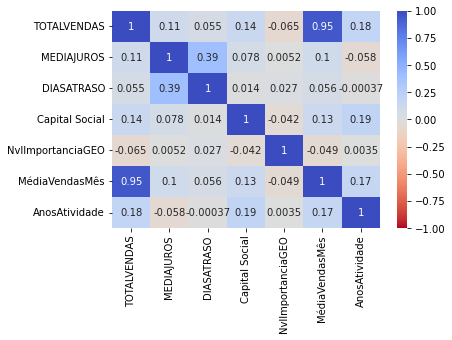

In [44]:
numericals = ['TOTALVENDAS', 'MEDIAJUROS', 'DIASATRASO', 'Capital Social', 
              'NvlImportanciaGEO', 'MédiaVendasMês', 'AnosAtividade']
sns.heatmap(df[numericals].corr(), annot=True, vmin=-1, cmap='coolwarm_r')

<font color=red>Como esperado, a feature de MédiaVendasMês e Total Vendas estão fortemente correlacionadas, sendo assim, iremos remover a coluna de TotalVendas. Também houve uma correlação moderada entre as colunas de DiasAtraso e MediaJuros, porém, optei por mantê-las por enquanto.<font color=red>

In [45]:
df = df.drop('TOTALVENDAS', axis=1)
numericals.pop(0)

'TOTALVENDAS'

- Resumo dos dados

In [46]:
for feature_nn in df[numericals]:
    print(feature_nn.center(100, '*'))
    print(f'Tipo da variável: {df[feature_nn].dtype}')
    print(f'{(sum(df[feature_nn].isna()) / rows_df) * 100:.2f}% das features são missing.')
    print(f'Os {sum(~df[feature_nn].isna())} dados, estão distribuidos em {len(df[feature_nn].value_counts())} valores diferentes.\n')

*********************************************MEDIAJUROS*********************************************
Tipo da variável: float64
0.00% das features são missing.
Os 428 dados, estão distribuidos em 131 valores diferentes.

*********************************************DIASATRASO*********************************************
Tipo da variável: float64
0.00% das features são missing.
Os 428 dados, estão distribuidos em 227 valores diferentes.

*******************************************Capital Social*******************************************
Tipo da variável: float64
0.00% das features são missing.
Os 428 dados, estão distribuidos em 124 valores diferentes.

*****************************************NvlImportanciaGEO******************************************
Tipo da variável: float64
1.64% das features são missing.
Os 421 dados, estão distribuidos em 100 valores diferentes.

*******************************************MédiaVendasMês*******************************************
Tipo da variável: f

- Distribuição dos dados

In [47]:
df[numericals].describe()

,MEDIAJUROS,DIASATRASO,Capital Social,NvlImportanciaGEO,MédiaVendasMês,AnosAtividade
count,428.000,428.000,428.000,421.000,428.000,428.000
mean,1.959,0.258,2252018.133,0.794,3562.989,13.395
std,7.979,4.820,11559937.206,0.122,7842.197,9.471
min,0.000,-64.000,0.000,0.460,0.000,0.540
25%,0.000,0.000,93700.000,0.697,0.000,6.290
50%,0.000,0.000,135000.000,0.791,978.925,11.140
75%,0.137,0.590,687625.000,0.886,3568.095,18.233
max,71.930,37.182,192505086.000,1.044,96741.150,54.000


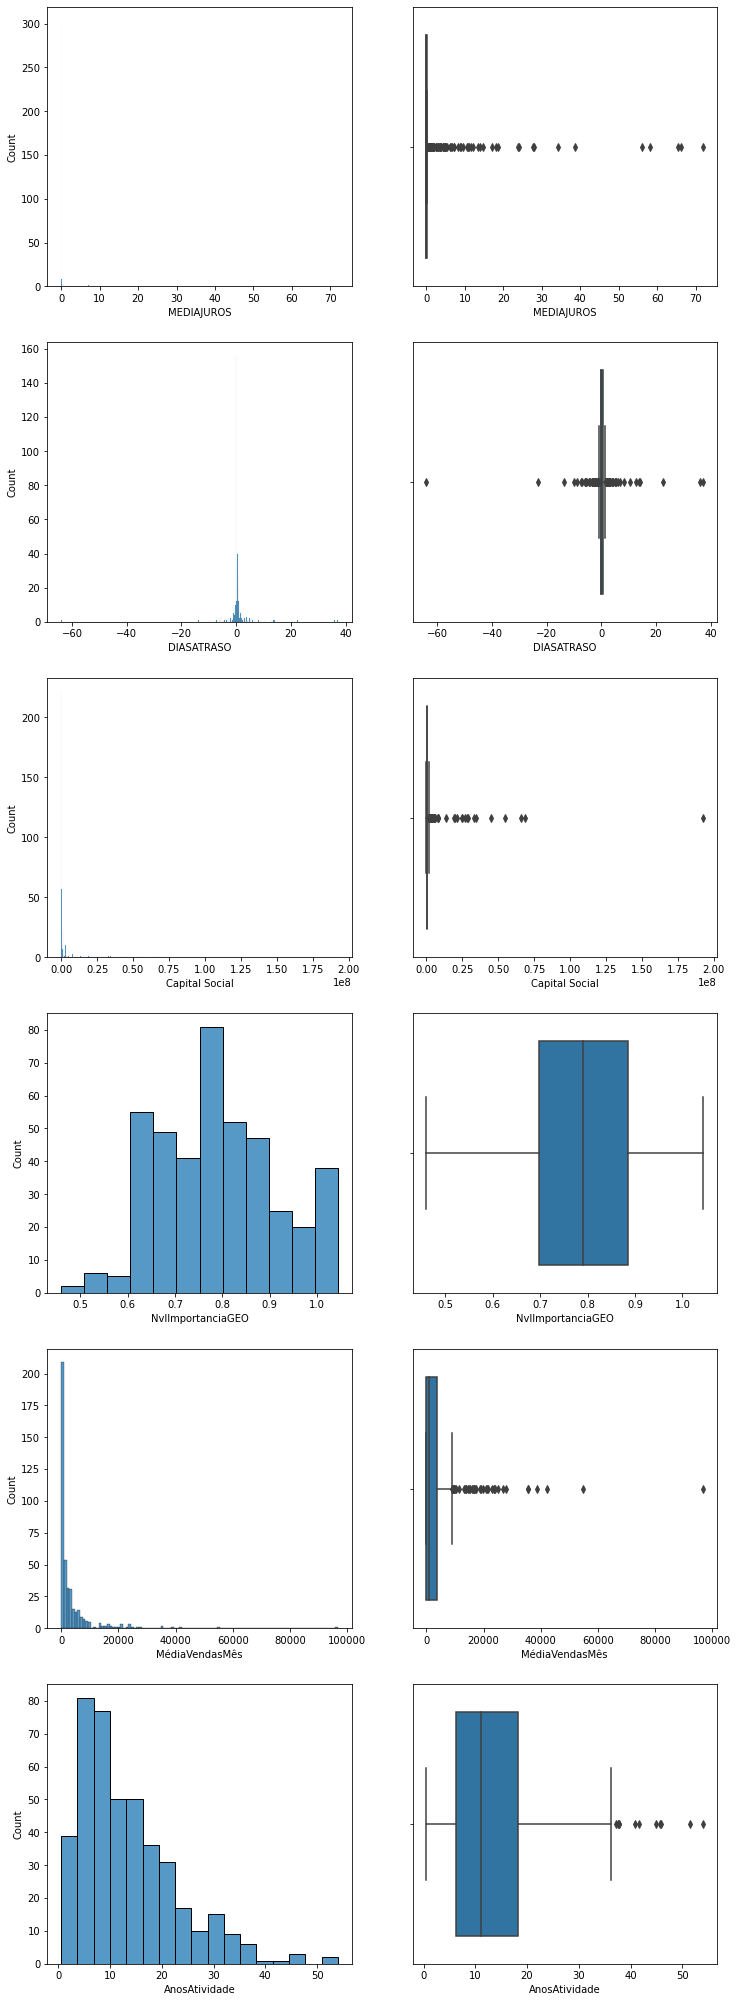

In [48]:
fig, ax = plt.subplots(len(numericals), 2, figsize=(12, 36))

for i, col in enumerate(df[numericals].columns):
    axes_hist = ax[i][0]
    axes_box  = ax[i][1]
    sns.histplot(data=df, x=col, ax=axes_hist)
    sns.boxplot(x=col, data=df, ax=axes_box)

<font color=red>Alguns Boxplots ficaram concentrados em escalas curtas (próximas de zero). Daremos uma olhada mais afundo à seguir.<font color=red>

In [49]:
for i, col in enumerate(df[numericals].columns):
    zeros = df[col].loc[df[col] > 0].count()
    print(f'A coluna {col} tem {zeros} ({zeros/df[col].shape[0]*100:.2f}%) amostras diferentes de zero.')

A coluna MEDIAJUROS tem 130 (30.37%) amostras diferentes de zero.
A coluna DIASATRASO tem 206 (48.13%) amostras diferentes de zero.
A coluna Capital Social tem 425 (99.30%) amostras diferentes de zero.
A coluna NvlImportanciaGEO tem 421 (98.36%) amostras diferentes de zero.
A coluna MédiaVendasMês tem 308 (71.96%) amostras diferentes de zero.
A coluna AnosAtividade tem 428 (100.00%) amostras diferentes de zero.


- Tratamento de missing values

In [50]:
print('Percentual de features vazias:')
percent_missing = (df.isnull().sum() / df.shape[0]) * 100
percent_missing

Percentual de features vazias:


MEDIAJUROS                                                                                   0.000
DIASATRASO                                                                                   0.000
Capital Social                                                                               0.000
Porte                                                                                        0.000
Latitude                                                                                     1.636
Longitude                                                                                    1.636
NvlImportanciaGEO                                                                            1.636
3312103                                                                                      0.000
3319800                                                                                      0.000
4618402                                                                                      0.000
4619200   

<font color=red>Como tivemos poucas amostras missing, optarei por remover as mesmas e prosseguir com o PCA e modelo.<font color=red>

In [51]:
print(f'Quantidade de linhas pré-drop: {df.shape[0]}.')
df = df.dropna()
print(f'Quantidade de linhas pós-drop: {df.shape[0]}.')

Quantidade de linhas pré-drop: 428.
Quantidade de linhas pós-drop: 421.


# Normalizando os dados (scalling)

In [55]:
df.describe()

,MEDIAJUROS,DIASATRASO,Capital Social,Porte,Latitude,Longitude,NvlImportanciaGEO,3312103,3319800,4618402,4619200,4644301,4645101,4645102,4645103,4646001,4646002,4649408,4664800,4773300,4930201,4930202,5211799,7020400,7729203,7739002,8650099,Região_Outra,Região_Região Geográfica Intermediária de Belo Horizonte,Região_Região Geográfica Intermediária de Campinas,Região_Região Geográfica Intermediária de Campo Grande,Região_Região Geográfica Intermediária de Curitiba,Região_Região Geográfica Intermediária de Goiânia,Região_Região Geográfica Intermediária de Manaus,Região_Região Geográfica Intermediária de Ribeirão Preto,Região_Região Geográfica Intermediária de Salvador,Região_Região Geográfica Intermediária de São Paulo,Região_Região Geográfica Intermediária de Vitória,Região_Região Geográfica Intermediária do Distrito Federal,Região_Região Geográfica Intermediária do Recife,Região_Região Geográfica Intermediária do Rio de Janeiro,Natureza Jurídica_Empresa Individual de Responsabilidade Limitada (de Natureza Empresária),Natureza Jurídica_Empresário (Individual),Natureza Jurídica_Sociedade Anônima Aberta,Natureza Jurídica_Sociedade Anônima Fechada,Natureza Jurídica_Sociedade Empresária Limitada,AnosAtividade,MédiaVendasMês
count,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000
mean,1.992,0.275,2284165.228,3.337,-19.226,-45.696,0.794,0.010,0.014,0.021,0.002,0.012,0.691,0.067,0.002,0.000,0.000,0.000,0.057,0.100,0.000,0.000,0.007,0.002,0.000,0.014,0.000,0.245,0.062,0.078,0.026,0.024,0.021,0.021,0.029,0.031,0.259,0.031,0.038,0.029,0.107,0.157,0.012,0.005,0.017,0.810,13.307,3589.245
std,8.041,4.850,11652816.584,1.601,6.680,5.063,0.122,0.097,0.119,0.145,0.049,0.108,0.463,0.249,0.049,0.000,0.000,0.000,0.232,0.300,0.000,0.000,0.084,0.049,0.000,0.119,0.000,0.430,0.241,0.269,0.160,0.152,0.145,0.145,0.167,0.173,0.439,0.173,0.191,0.167,0.309,0.364,0.108,0.069,0.128,0.393,9.495,7894.368
min,0.000,-64.000,0.000,1.000,-30.032,-67.822,0.460,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.540,0.000
25%,0.000,0.000,95400.000,3.000,-23.551,-47.649,0.697,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,6.280,0.000
50%,0.000,0.000,150000.000,3.000,-22.438,-46.569,0.791,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,11.060,1009.190
75%,0.140,0.600,700000.000,5.000,-16.681,-43.209,0.886,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,17.850,3586.740
max,71.930,37.182,192505086.000,5.000,2.821,-34.835,1.044,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,54.000,96741.150


In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_norm = MinMaxScaler()
df_norm = standard_norm.fit_transform(df)

<font color=red>Optei por utilizar o MinMax por conta do peso que o modelo dá para os outliers (valores altos positivamente ou negativamente).<font color=red>

# PCA

In [62]:
print(f'Número de colunas atuais: {df_norm.shape[1]}.')

Número de colunas atuais: 48.


In [70]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=15)
pca_model.fit_transform(df_norm)

sum(pca_model.explained_variance_ratio_)


0.8563330515434031